In [4]:
# Imports
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add path to wasp module (ensure it's at the beginning of sys.path)
wasp_path = os.path.abspath("../src")
if wasp_path in sys.path:
    sys.path.remove(wasp_path)
sys.path.insert(0, wasp_path)

# Remove cached wasp modules to force reload
modules_to_remove = [key for key in sys.modules.keys() if key.startswith('wasp')]
for module in modules_to_remove:
    del sys.modules[module]

# Import wasp functions
import wasp
from wasp import (
    find_station_file, 
    find_closest_time, 
    load_ndbc_spectrum,
    partition_spectrum,
    calculate_wave_parameters
)
from wasp.plotting import plot_directional_spectrum

print(f"✓ WASP version: {wasp.__version__}")
print(f"✓ WASP location: {wasp.__file__}")
print(f"✓ Loaded modules: io_ndbc, partition, wave_params, plotting")

✓ WASP version: 0.1.1
✓ WASP location: /Users/jtakeo/googleDrive/myProjects/wasp/src/wasp/__init__.py
✓ Loaded modules: io_ndbc, partition, wave_params, plotting


## 1. Configuration and Data Loading

Loading NDBC buoy spectral data using wasp functions

In [16]:
# NDBC data directory and parameters
ndbc_data_dir = '/Users/jtakeo/data/ndbc'

# Station to analyze
station_id = 41001  # Example: NDBC station 41010

# Target time for analysis
target_time = pd.to_datetime('2020-12-01 00:00:00')

print(f"Configuration:")
print(f"  Station ID: {station_id}")
print(f"  Target time: {target_time}")
print(f"  Data directory: {ndbc_data_dir}")

Configuration:
  Station ID: 41001
  Target time: 2020-12-01 00:00:00
  Data directory: /Users/jtakeo/data/ndbc


## 2. Load NDBC Spectrum

NDBC provides:
- 1D spectral density in m²/Hz
- Fourier coefficients (r1, r2, α1, α2) for directional reconstruction

The 2D spectrum is reconstructed using the Maximum Entropy Method (MEM)

In [17]:
# Find and load NDBC file
year = target_time.year
ndbc_file = find_station_file(ndbc_data_dir, station_id, year)

if ndbc_file is None:
    print(f"❌ NDBC file not found for station {station_id}, year {year}")
else:
    print(f"✓ Found file: {ndbc_file}")
    
    # Open dataset
    ds = xr.open_dataset(ndbc_file)
    
    # Find closest time
    itime, selected_time, time_diff_hours = find_closest_time(ds, target_time)
    
    print(f"\n📅 Time matching:")
    print(f"   Target time: {target_time}")
    print(f"   Closest time: {selected_time}")
    print(f"   Time difference: {time_diff_hours:.2f} hours")
    
    # Load 2D spectrum
    spectrum_data = load_ndbc_spectrum(ds, itime, direction_resolution=15)
    
    if spectrum_data is not None:
        E2d, freq, dirs, dirs_rad, lon, lat = spectrum_data
        
        print(f"\n📊 Spectrum loaded:")
        print(f"   Location: {lon:.2f}°E, {lat:.2f}°N")
        print(f"   Frequencies: {len(freq)} bins ({freq[0]:.4f} - {freq[-1]:.4f} Hz)")
        print(f"   Directions: {len(dirs)} bins ({dirs[0]:.1f}° - {dirs[-1]:.1f}°)")
        print(f"   E2d shape: {E2d.shape}")
    else:
        print("❌ Failed to load spectrum")

✓ Found file: /Users/jtakeo/data/ndbc/41001w2020.nc

📅 Time matching:
   Target time: 2020-12-01 00:00:00
   Closest time: 2020-12-01 00:00:00
   Time difference: 0.00 hours

📊 Spectrum loaded:
   Location: -72.32°E, 34.72°N
   Frequencies: 47 bins (0.0200 - 0.4850 Hz)
   Directions: 24 bins (0.0° - 345.0°)
   E2d shape: (47, 24)


## 3. Calculate Integrated Wave Parameters

Calculate Hs, Tp, Dp from the 2D spectrum using trapezoidal integration

In [18]:
# Calculate Hs, Tp, Dp using trapezoidal integration
hs, tp, dp, m0, delf, ddir, i_peak, j_peak = calculate_wave_parameters(E2d, freq, dirs_rad)

# Get NDBC reported values from file
try:
    wvht_ndbc = float(ds['wave_height'].isel(time=itime).values)
    dpd_ndbc = float(ds['dominant_wave_period'].isel(time=itime).values)
    mwd_ndbc = float(ds['mean_wave_dir'].isel(time=itime).values)
    has_ndbc_values = True
except:
    has_ndbc_values = False

# Display summary
print("\n" + "="*70)
print(" NDBC SPECTRUM INTEGRATED PARAMETERS")
print("="*70)
print(f"Station: {station_id}")
print(f"Location: {lon:.2f}°E, {lat:.2f}°N")
print(f"Time: {selected_time}")
print("─"*70)

print(f"\n📊 Calculated (from 2D spectrum):")
print(f"   m0 = {m0:.6f} m²")
print(f"   Hs = {hs:.2f} m")
print(f"   Tp = {tp:.2f} s")
print(f"   Dp = {dp:.0f}°")

if has_ndbc_values:
    print(f"\n📋 NDBC Reported values:")
    print(f"   Hs = {wvht_ndbc:.2f} m")
    print(f"   Tp = {dpd_ndbc:.2f} s")
    print(f"   Dp = {mwd_ndbc:.0f}°")
    
    print(f"\n📏 Differences:")
    print(f"   ΔHs = {hs - wvht_ndbc:.2f} m ({((hs/wvht_ndbc - 1)*100):.1f}%)")
    print(f"   ΔTp = {tp - dpd_ndbc:.2f} s ({((tp/dpd_ndbc - 1)*100):.1f}%)")

print("="*70)


 NDBC SPECTRUM INTEGRATED PARAMETERS
Station: 41001
Location: -72.32°E, 34.72°N
Time: 2020-12-01 00:00:00
──────────────────────────────────────────────────────────────────────

📊 Calculated (from 2D spectrum):
   m0 = 2.029405 m²
   Hs = 5.70 m
   Tp = 10.00 s
   Dp = 164°


## 4. Plot Directional Spectrum

Polar plot showing energy distribution by frequency (period) and direction

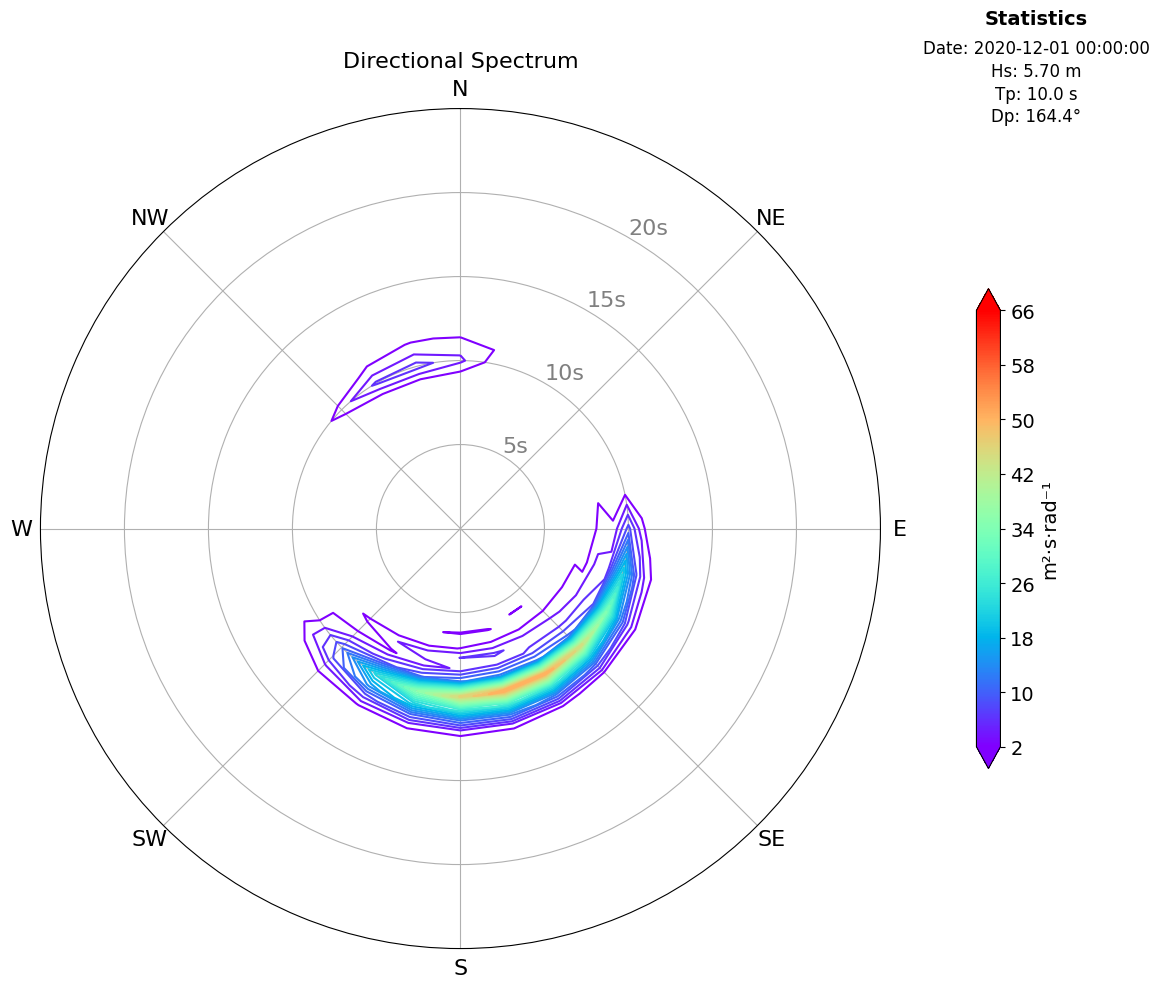

In [19]:
# Plot directional spectrum in polar coordinates
fig, ax = plot_directional_spectrum(
    E2d, 
    freq, 
    dirs,
    selected_time=selected_time,
    hs=hs,
    tp=tp,
    dp=dp
)

plt.show()

## 5. Spectral Partitioning

Apply spectral partitioning to identify wave systems (swell and wind sea)

In [20]:
# Apply partitioning with NDBC-specific parameters
# NDBC has low directional resolution, so we use:
# - Lower threshold (98.0) to capture all real peaks
# - Higher merge_factor (0.7) to aggressively merge nearby systems
# This prevents over-partitioning caused by MEM directional spreading

results = partition_spectrum(
    E2d, freq, dirs_rad,
    threshold_mode='adaptive',
    threshold_percentile=98.0,  # Liberal: captures all peaks in low-resolution data
    merge_factor=0.7            # Aggressive: merges nearby systems from MEM artifacts
)

if results is None:
    print("No spectral peaks identified!")
else:
    # Partitioning process information
    n_peaks_initial = len(results['peaks'])
    
    # Count how many partitions really have significant energy (> 1% of total for NDBC)
    min_energy_threshold = 0.01 * results['total_m0']  # 1% of total energy
    n_partitions_final = 0
    for i in range(1, len(results['Hs'])):
        if results['energy'][i] > min_energy_threshold:
            n_partitions_final += 1
    
    print("\n" + "="*70)
    print(" SPECTRAL PARTITIONING - PROCESS SUMMARY")
    print("="*70)
    print(f"🔍 Spectral peaks initially identified: {n_peaks_initial}")
    print(f"🔗 After merging nearby systems: {n_partitions_final} partition(s)")
    print("="*70)
    
    print("\n" + "="*70)
    print(" PARTITIONING RESULTS")
    print("="*70)
    print(f"Number of partitions found: {n_partitions_final}")
    print("─"*70)
    
    # Display information for each partition that actually exists
    partition_count = 0
    for i in range(1, len(results['Hs'])):
        if results['energy'][i] > min_energy_threshold:  # Only significant energy
            partition_count += 1
            print(f"\nPartition {partition_count}:")
            print(f"  Hs = {results['Hs'][i]:.2f} m")
            print(f"  Tp = {results['Tp'][i]:.2f} s")
            print(f"  Dp = {results['Dp'][i]:.0f}°")
            print(f"  Energy: {results['energy'][i]:.4f} m²")
            print(f"  Energy fraction: {(results['energy'][i]/results['total_m0'])*100:.1f}%")
    
    print("\n" + "─"*70)
    print(f"Integrated total:")
    print(f"  Hs = {results['total_Hs']:.2f} m")
    print(f"  Tp = {results['total_Tp']:.2f} s")
    print(f"  Dp = {results['total_Dp']:.0f}°")
    print("="*70)


Identifying spectral peaks with threshold: 5.00e-02
Spectrum values: min=0.00e+00, max=5.20e+01, mean=8.35e-01
Limiting number of peaks from 17 to 5
Identified 5 spectral peaks
Generating mask from ICOD...
Calculating distances between peaks...
Calculating peak spreading...
Checking for overlapping systems...
Number of masks: 5
[DEBUG] Sum of partition energies: 2.202282
[DEBUG] Expected total: 2.202282
Total spectrum energy: 2.029405
Sum of partitioned energies: 2.202282

 SPECTRAL PARTITIONING - PROCESS SUMMARY
🔍 Spectral peaks initially identified: 5
🔗 After merging nearby systems: 5 partition(s)

 PARTITIONING RESULTS
Number of partitions found: 5
──────────────────────────────────────────────────────────────────────

Partition 1:
  Hs = 5.24 m
  Tp = 10.00 s
  Dp = 158°
  Energy: 1.7194 m²
  Energy fraction: 84.7%

Partition 2:
  Hs = 1.45 m
  Tp = 5.88 s
  Dp = 146°
  Energy: 0.1314 m²
  Energy fraction: 6.5%

Partition 3:
  Hs = 1.43 m
  Tp = 7.69 s
  Dp = 183°
  Energy: 0.1279 

## 6. Plot Partitions

Visualize individual wave systems identified by the partitioning algorithm

/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_39889/3151606447.py:31: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax2.contour(theta, r, E_part, levels=levels_part,


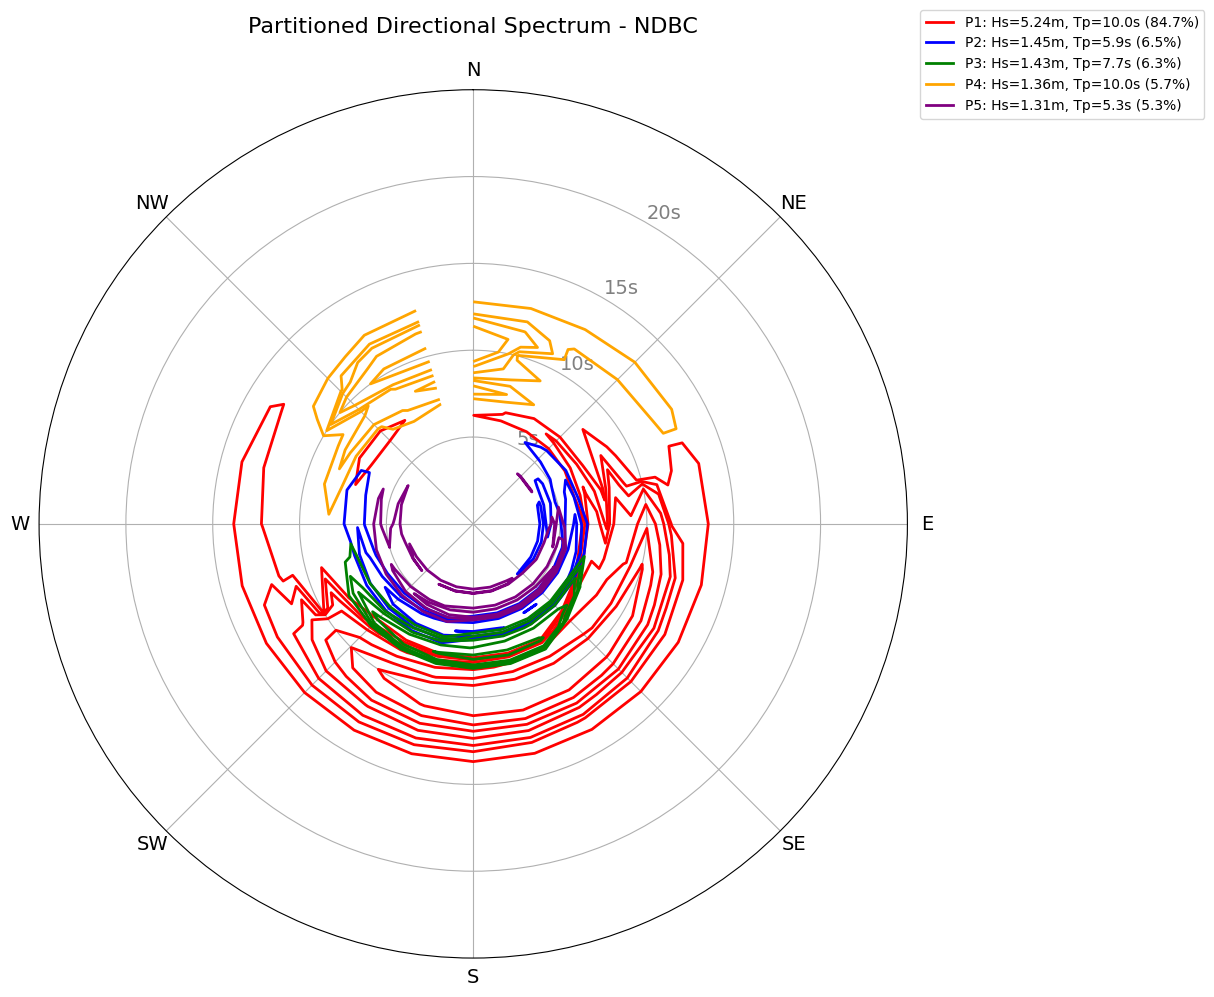

In [21]:
# Plot individual partitions in polar spectrum
fig2, ax2 = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Prepare data
freq_plot = np.asarray(freq).flatten()
dirs_plot = np.asarray(dirs).flatten()
dirs_rad_plot = np.radians(dirs_plot)

# Convert to period
with np.errstate(divide='ignore', invalid='ignore'):
    period = np.where(freq_plot > 0, 1.0 / freq_plot, 0)

# Create meshgrid
theta, r = np.meshgrid(dirs_rad_plot, period)

# Colors for each partition
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
min_energy_threshold = 0.01 * results['total_m0']  # 1% to show all significant partitions

# Plot contours for each partition
partition_count = 0
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > min_energy_threshold:
        # Create spectrum for this partition only
        E_part = np.zeros_like(E2d)
        mask = (results['mask'] == i)
        E_part[mask] = E2d[mask]
        
        # Plot contour
        levels_part = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
        cs = ax2.contour(theta, r, E_part, levels=levels_part, 
                        colors=colors[partition_count % len(colors)], linewidths=2,
                        label=f'Partition {partition_count+1}')
        
        partition_count += 1

# Configure axes
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_rticks([5, 10, 15, 20])
ax2.set_yticklabels(['5s', '10s', '15s', '20s'], color='gray', fontsize=12)
ax2.set_rlim(0, 25)
ax2.set_rlabel_position(30)
ax2.tick_params(axis='y', colors='gray', labelsize=14)

ticks = ['N','NE','E','SE','S','SW','W','NW']
tick_angles = np.deg2rad(np.linspace(0, 315, 8))
ax2.set_xticks(tick_angles)
ax2.set_xticklabels(ticks, fontsize=14)

ax2.set_title('Partitioned Directional Spectrum - NDBC', fontsize=16, pad=20)

# Legend
from matplotlib.lines import Line2D
legend_elements = []
partition_count = 0
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > min_energy_threshold:
        pct = (results['energy'][i]/results['total_m0'])*100
        label = f'P{partition_count+1}: Hs={results["Hs"][i]:.2f}m, Tp={results["Tp"][i]:.1f}s ({pct:.1f}%)'
        legend_elements.append(Line2D([0], [0], color=colors[partition_count % len(colors)], lw=2, label=label))
        partition_count += 1

ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=10)

plt.tight_layout()
plt.show()

In [22]:
# Diagnóstico: ver todas as energias das partições para decidir o threshold
print("\n" + "="*70)
print(" DIAGNÓSTICO - TODAS AS PARTIÇÕES E SUAS ENERGIAS")
print("="*70)
print(f"Energia total (m0): {results['total_m0']:.6f} m²")
print(f"Threshold atual (1%): {0.01 * results['total_m0']:.6f} m²")
print("\n" + "─"*70)

# Mostrar TODAS as partições, mesmo as com energia muito baixa
all_partitions = []
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > 0:  # Qualquer energia > 0
        percentage = (results['energy'][i] / results['total_m0']) * 100
        all_partitions.append({
            'id': i,
            'energy': results['energy'][i],
            'percentage': percentage,
            'Hs': results['Hs'][i]
        })

# Ordenar por energia (maior primeiro)
all_partitions.sort(key=lambda x: x['energy'], reverse=True)

print(f"Total de partições com energia > 0: {len(all_partitions)}\n")

for idx, part in enumerate(all_partitions, 1):
    marker = "★" if idx == 1 else " "
    print(f"{marker} Partição {idx} (ID={part['id']}):")
    print(f"    Energia: {part['energy']:.6f} m² ({part['percentage']:.2f}%)")
    print(f"    Hs: {part['Hs']:.3f} m")

print("\n" + "─"*70)
print("RECOMENDAÇÕES DE THRESHOLD:")

# Calcular thresholds para mostrar 1, 2, 3 sistemas
if len(all_partitions) >= 2:
    # Threshold para mostrar apenas 1 sistema = energia da 2ª partição
    threshold_1_system = all_partitions[1]['energy']
    threshold_1_pct = all_partitions[1]['percentage']
    print(f"  Para 1 sistema:  threshold > {threshold_1_pct:.2f}% ({threshold_1_system:.6f} m²)")

if len(all_partitions) >= 3:
    threshold_2_systems = all_partitions[2]['energy']
    threshold_2_pct = all_partitions[2]['percentage']
    print(f"  Para 2 sistemas: threshold > {threshold_2_pct:.2f}% ({threshold_2_systems:.6f} m²)")

if len(all_partitions) >= 4:
    threshold_3_systems = all_partitions[3]['energy']
    threshold_3_pct = all_partitions[3]['percentage']
    print(f"  Para 3 sistemas: threshold > {threshold_3_pct:.2f}% ({threshold_3_systems:.6f} m²)")

print("="*70)



 DIAGNÓSTICO - TODAS AS PARTIÇÕES E SUAS ENERGIAS
Energia total (m0): 2.029405 m²
Threshold atual (1%): 0.020294 m²

──────────────────────────────────────────────────────────────────────
Total de partições com energia > 0: 5

★ Partição 1 (ID=1):
    Energia: 1.719362 m² (84.72%)
    Hs: 5.245 m
  Partição 2 (ID=2):
    Energia: 0.131437 m² (6.48%)
    Hs: 1.450 m
  Partição 3 (ID=3):
    Energia: 0.127889 m² (6.30%)
    Hs: 1.430 m
  Partição 4 (ID=4):
    Energia: 0.115865 m² (5.71%)
    Hs: 1.362 m
  Partição 5 (ID=5):
    Energia: 0.107728 m² (5.31%)
    Hs: 1.313 m

──────────────────────────────────────────────────────────────────────
RECOMENDAÇÕES DE THRESHOLD:
  Para 1 sistema:  threshold > 6.48% (0.131437 m²)
  Para 2 sistemas: threshold > 6.30% (0.127889 m²)
  Para 3 sistemas: threshold > 5.71% (0.115865 m²)


# Saving results

In [23]:
import pandas as pd

# Define output directory and create if it doesn't exist
output_dir = '../data/ndbc/partition'
os.makedirs(output_dir, exist_ok=True)

# Reference ID (station ID)
referencia = station_id

# Create filename with station ID and timestamp
output_filename = f'partition_ndbc_station_{referencia}_{selected_time.strftime("%Y%m%d_%H%M%S")}.csv'
output_path = os.path.join(output_dir, output_filename)

# Get moments from results
moments = results['moments']
m0_total = moments['total'][0]
m1_total = moments['total'][1]
m2_total = moments['total'][2]

# Prepare data dictionary
data = {
    'station_id': referencia,
    'obs_time': selected_time,
    'longitude': float(lon),
    'latitude': float(lat),
    'source_file': ndbc_file.name,
    
    # Total spectrum
    'total_energy': results['total_m0'],
    'total_Hs': results['total_Hs'],
    'total_Tp': results['total_Tp'],
    'total_Dp': results['total_Dp'],
    'total_m0': m0_total,
    'total_m1': m1_total,
    'total_m2': m2_total,
}

# Add partition data (up to 3 partitions)
for p in range(1, 4):
    if p < len(results['Hs']) and results['energy'][p] > min_energy_threshold:
        data[f'P{p}_energy'] = results['energy'][p]
        data[f'P{p}_Hs'] = results['Hs'][p]
        data[f'P{p}_Tp'] = results['Tp'][p]
        data[f'P{p}_Dp'] = results['Dp'][p]
        data[f'P{p}_m0'] = moments['m0'][p]
        data[f'P{p}_m1'] = moments['m1'][p]
        data[f'P{p}_m2'] = moments['m2'][p]
    else:
        data[f'P{p}_energy'] = 0.0
        data[f'P{p}_Hs'] = 0.0
        data[f'P{p}_Tp'] = 0.0
        data[f'P{p}_Dp'] = 0.0
        data[f'P{p}_m0'] = 0.0
        data[f'P{p}_m1'] = 0.0
        data[f'P{p}_m2'] = 0.0

# Create DataFrame
df_results = pd.DataFrame([data])

# Save to CSV
df_results.to_csv(output_path, index=False, float_format='%.6f')

print(f"\n✓ Results saved to: {output_path}")
print(f"\nColumns in CSV: {list(df_results.columns)}")
print(f"\nPreview:")
print(df_results.T)


✓ Results saved to: ../data/ndbc/partition/partition_ndbc_station_41001_20201201_000000.csv

Columns in CSV: ['station_id', 'obs_time', 'longitude', 'latitude', 'source_file', 'total_energy', 'total_Hs', 'total_Tp', 'total_Dp', 'total_m0', 'total_m1', 'total_m2', 'P1_energy', 'P1_Hs', 'P1_Tp', 'P1_Dp', 'P1_m0', 'P1_m1', 'P1_m2', 'P2_energy', 'P2_Hs', 'P2_Tp', 'P2_Dp', 'P2_m0', 'P2_m1', 'P2_m2', 'P3_energy', 'P3_Hs', 'P3_Tp', 'P3_Dp', 'P3_m0', 'P3_m1', 'P3_m2']

Preview:
                                0
station_id                  41001
obs_time      2020-12-01 00:00:00
longitude              -72.317001
latitude                34.723999
source_file         41001w2020.nc
total_energy             2.029405
total_Hs                 5.698287
total_Tp                     10.0
total_Dp               164.369334
total_m0                 2.202282
total_m1                 1.573402
total_m2                 1.233518
P1_energy                1.719362
P1_Hs                    5.244977
P1_Tp         